In [1]:
import config
from post_process.utils import load_data, preprocess_data, process_result, get_noise_S, result_process
from post_process.visual_result import contourDOSY
import scipy.io as scio
import torch
import matplotlib.pyplot as plt
from model.model import DReaM_net
import numpy as np
np.random.seed(40)
def process_data_and_plot(Type, noise=None, save=True, version="epoch=60-step=34343-v4.ckpt"):

    data = load_data(Type)
    hard, rate, sc_type, var_rate, expand = result_process(Type)
    test_input = preprocess_data(data['NmrData'], sc_type) #  linear or quadratic
    
    S = test_input/test_input[:,:,0:1]
    if(noise!=None):
        noise_S = get_noise_S(S, noise)
        S = noise_S/noise_S[:,:,0:1]
        
    S = torch.tensor(S, dtype=torch.float32)
    plt.plot(S[0].T)
    with torch.no_grad():
        module = DReaM_net.load_from_checkpoint(f"Result/DOSY/{version}")
        module.prepare_for_testing()
        test_out, var = module(S)
    
    test_out, var = test_out.squeeze(), torch.sqrt(var).squeeze()
    test_input = test_input/np.max(test_input[:, :, 0], 1)
    test_input_scaling = test_input[:, :, 0][:, :, np.newaxis].squeeze(0)
    test_out = (test_out * test_input_scaling / config.mul_label).cpu().numpy()
    var = (var * test_input_scaling/ config.mul_label).cpu().numpy()
    out_threshold = np.max(test_out, axis=1, keepdims=True) * rate
    test_out[test_out < out_threshold] = 0
    threshold = np.max(var, axis=1, keepdims=True) * var_rate
    var[var < threshold] = 0
    
    test_out[test_out < np.max(test_out) * hard] = 0
    var[var < np.max(var)*0.02] = 0

    spec_var, max_var, merged_boxes = process_result(Type, test_out, data['ppm'], var, data['idx_peaks'], data['HNMR'], expand)
    fig, axs = plt.subplots(2, 1, figsize=(10, 9))

    contourDOSY(data, Type, fig, axs, test_out, spec_var, max_var, merged_boxes)
    plt.show()
    if save == True:
        scio.savemat("./MATLAB/Result/" + Type + "_Result.mat", {"Z":test_out, "var":spec_var, "max_var":max_var,  "box":merged_boxes})


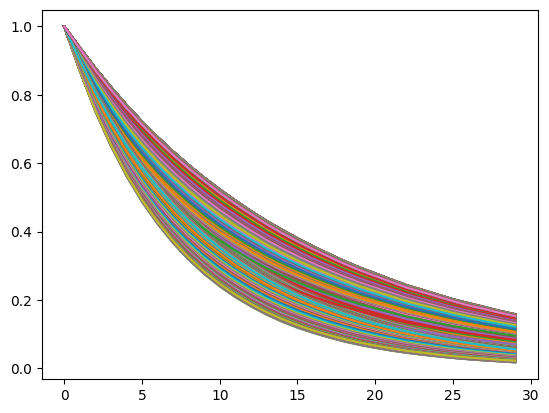

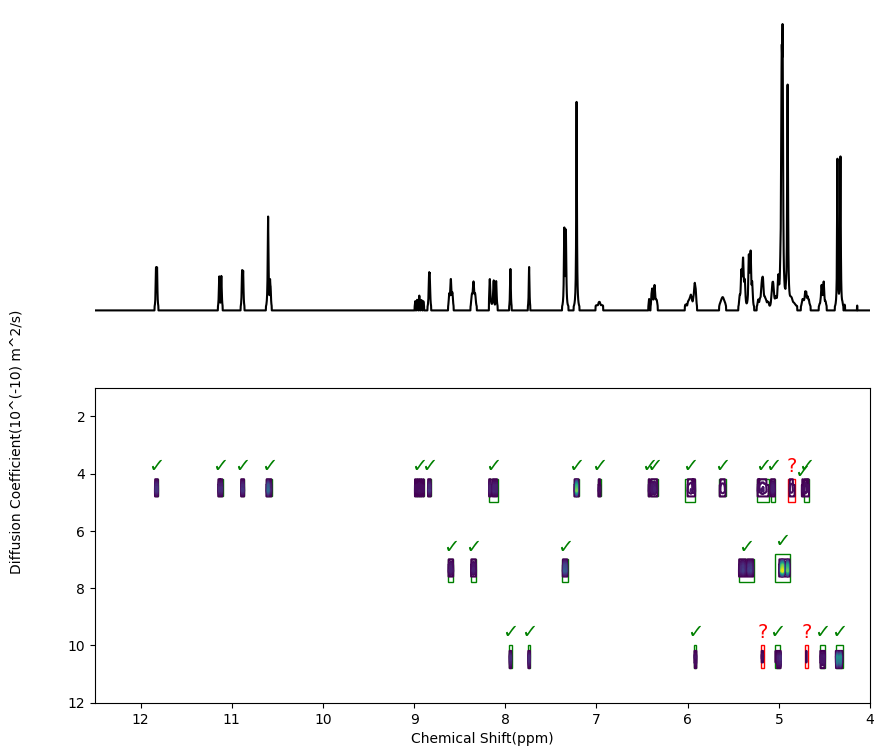

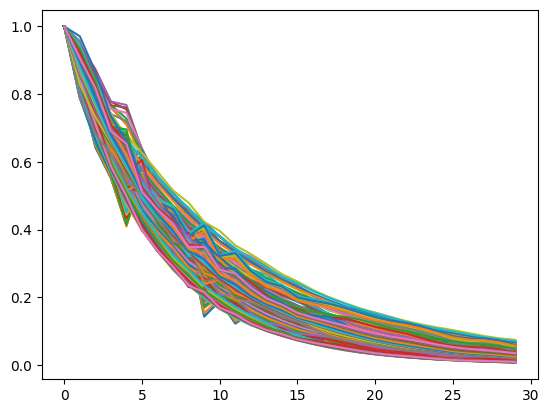

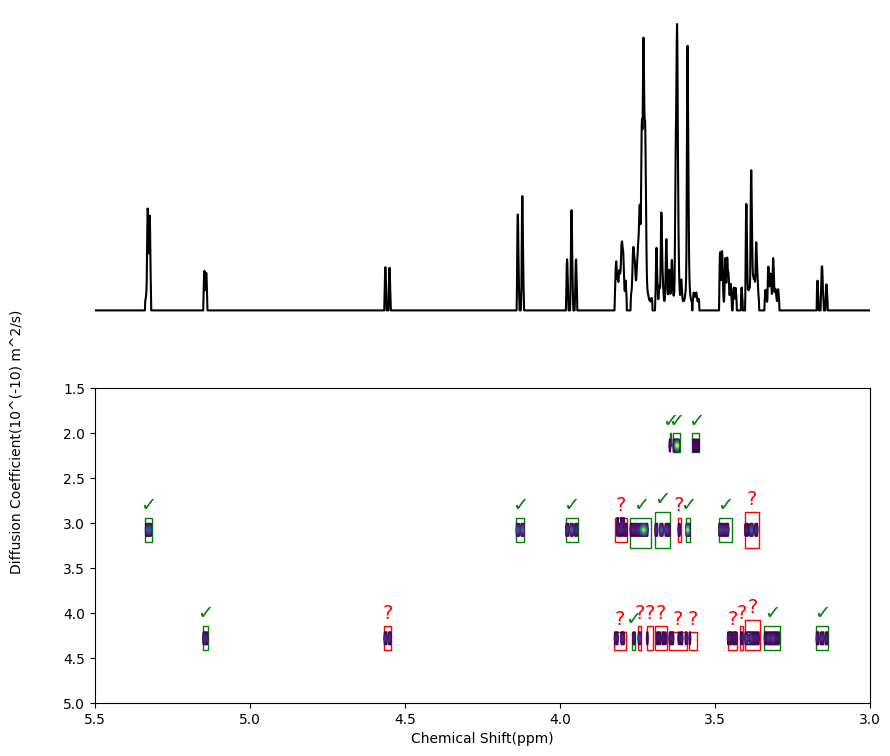

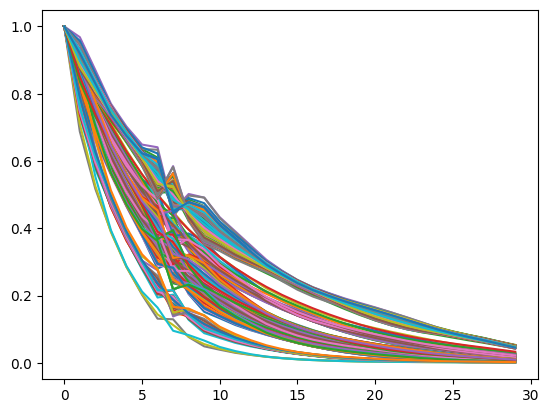

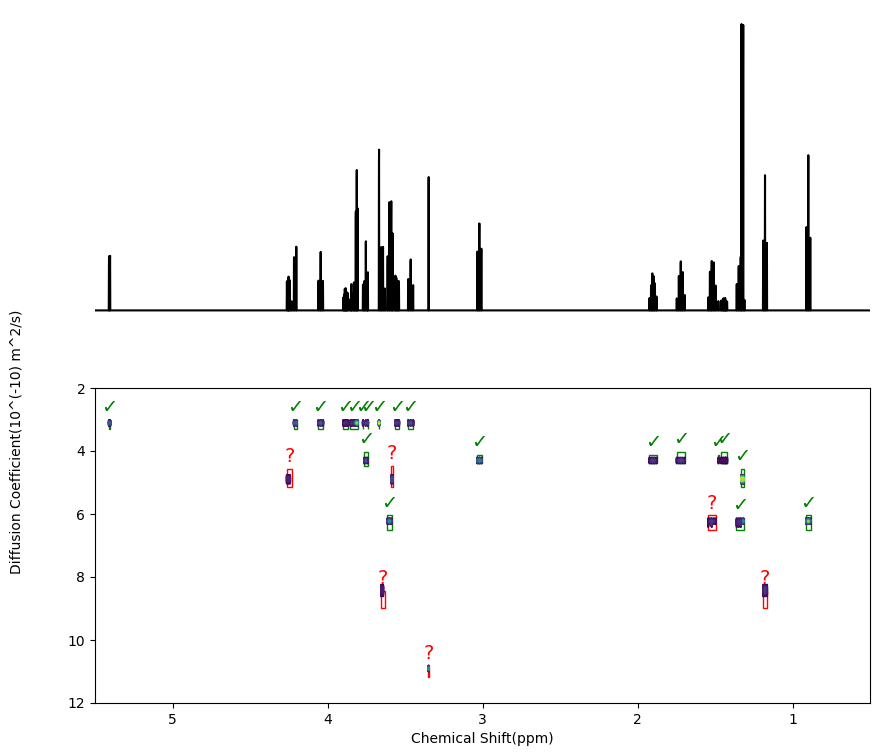

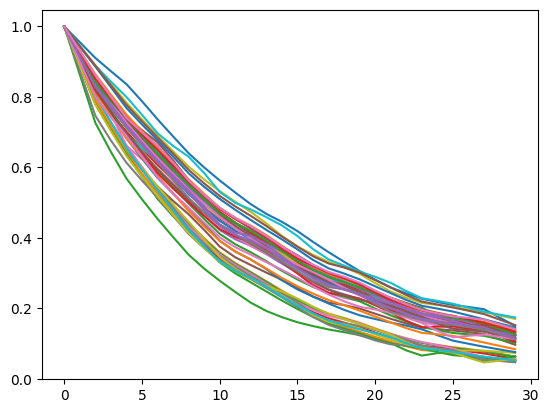

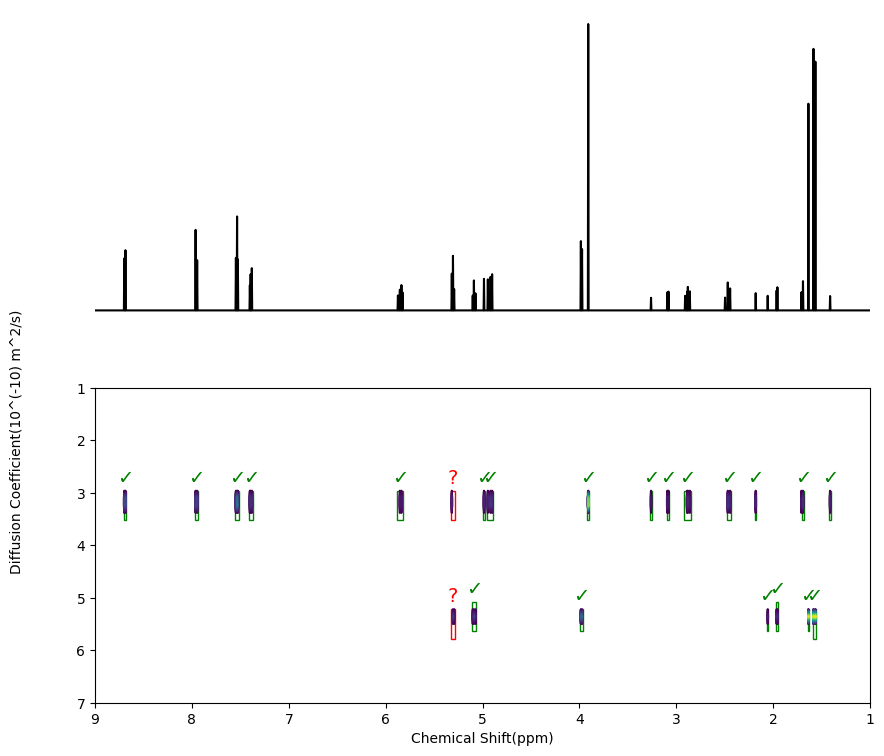

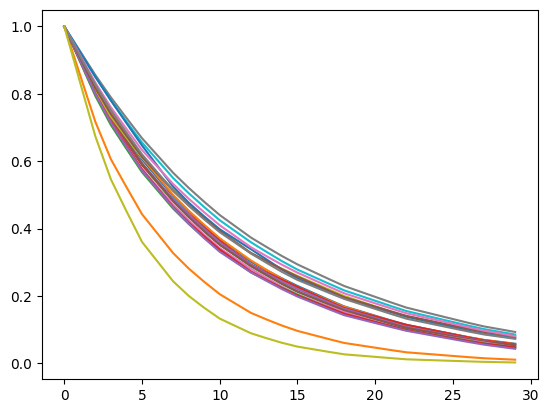

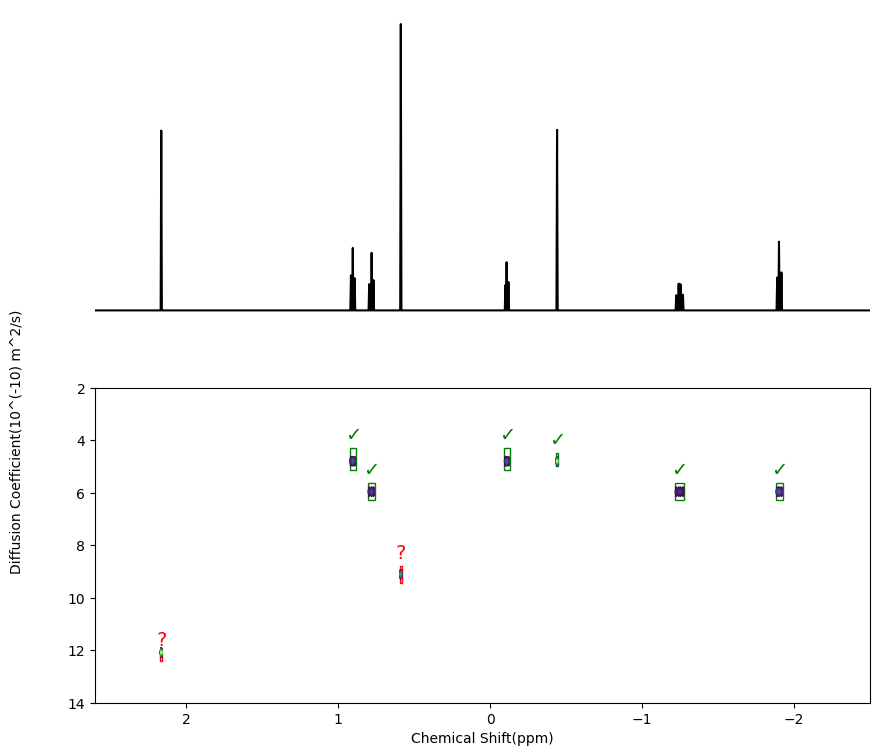

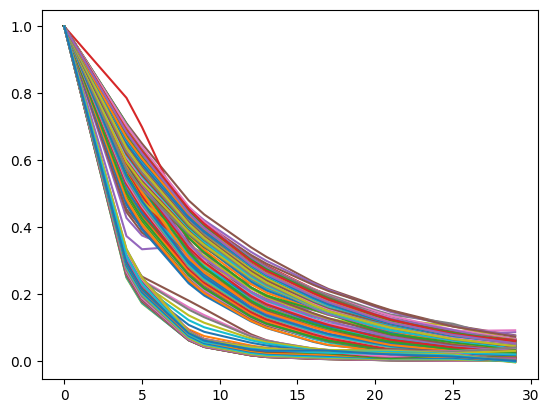

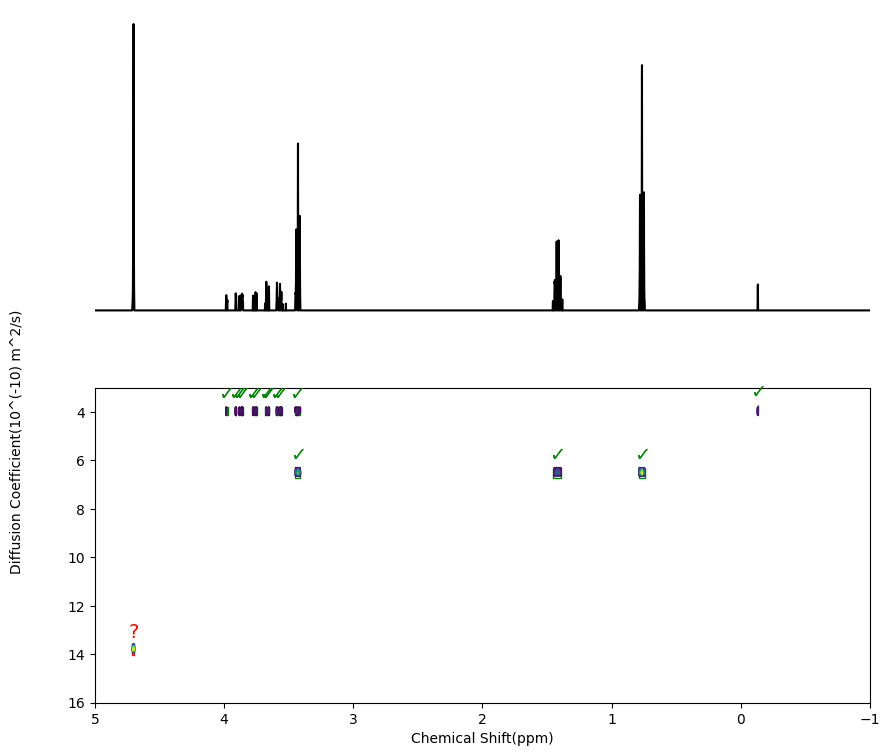

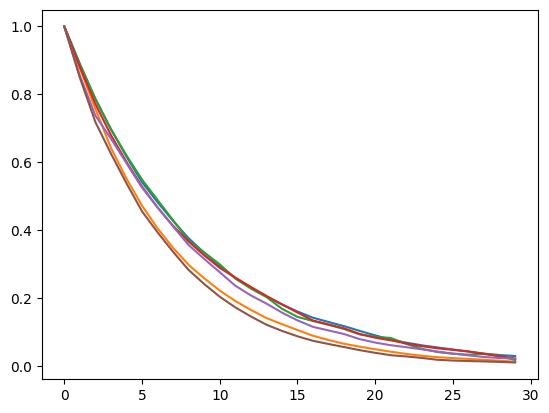

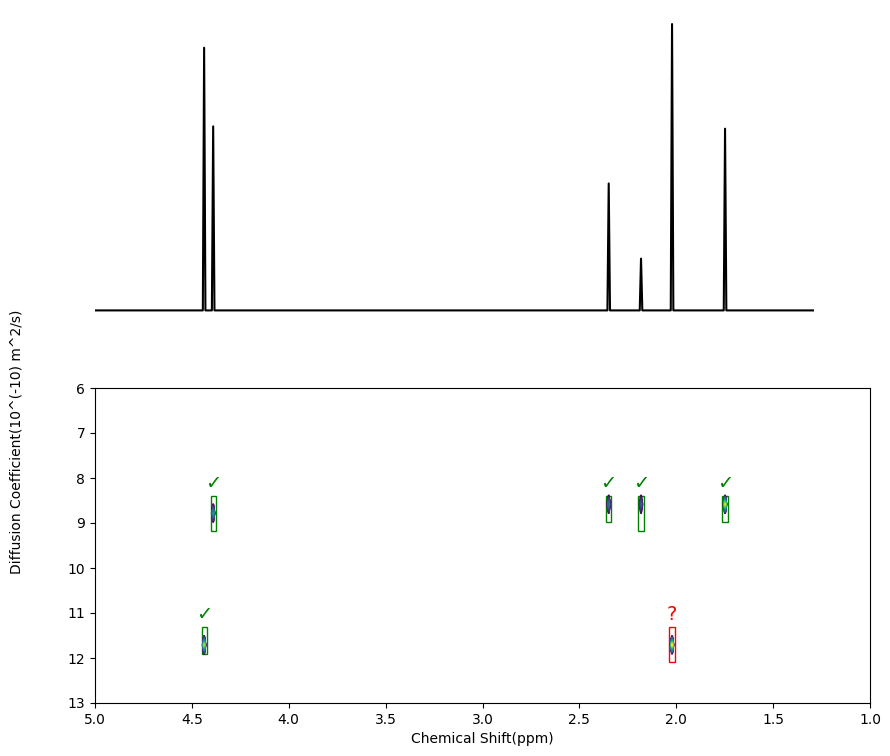

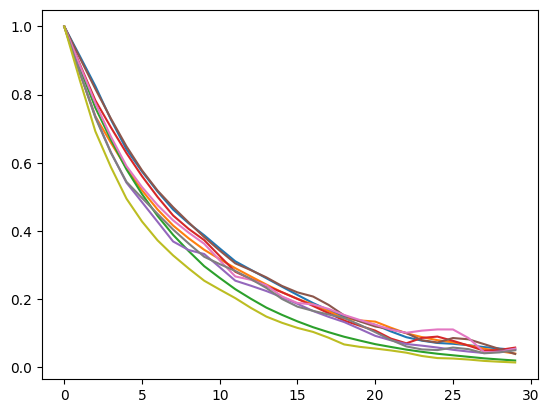

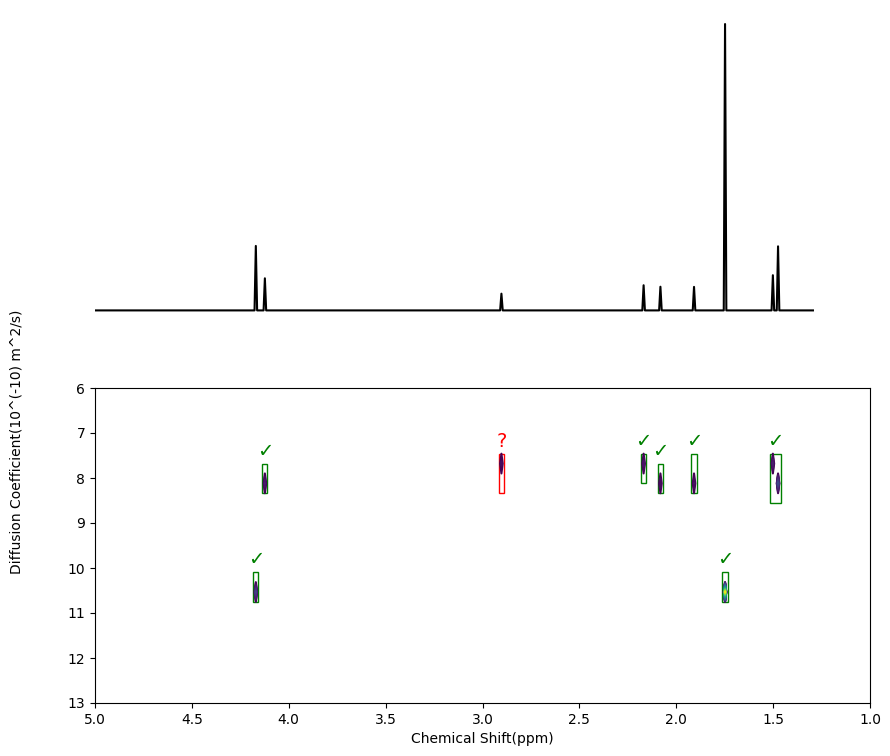

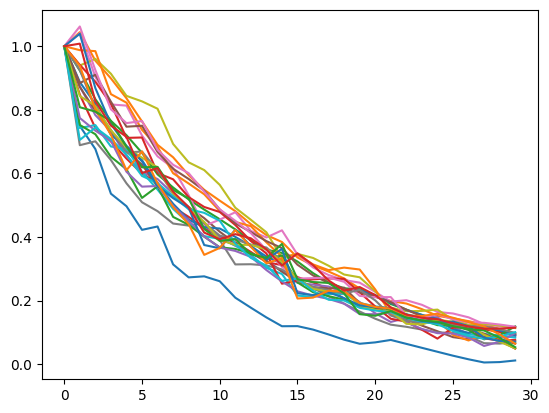

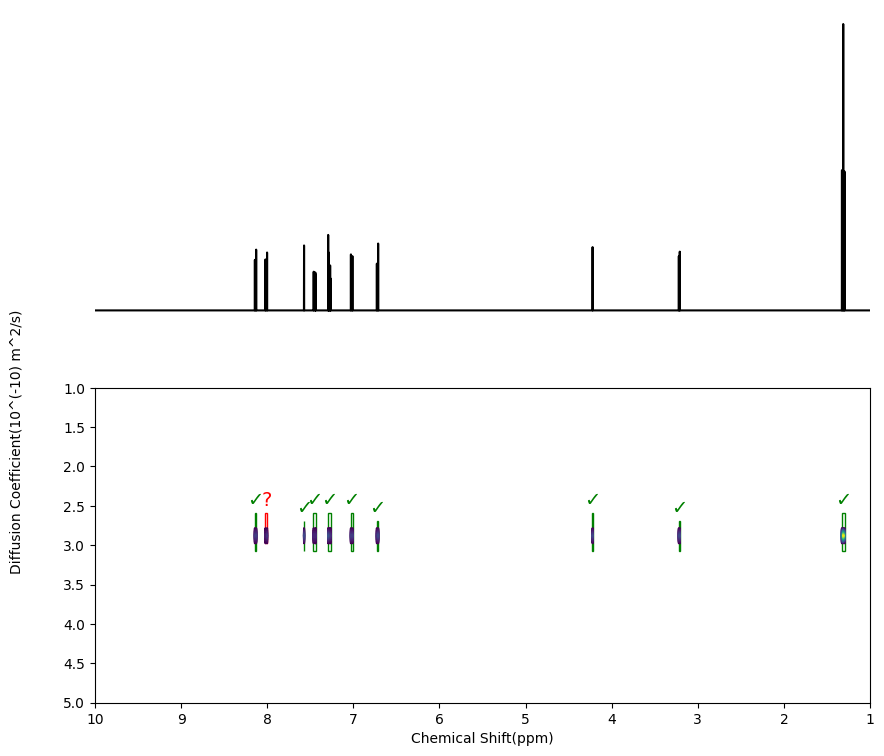

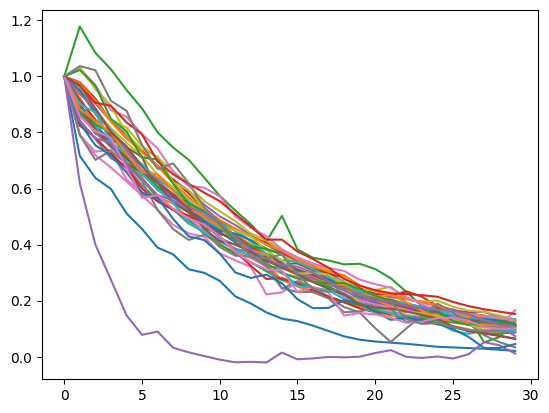

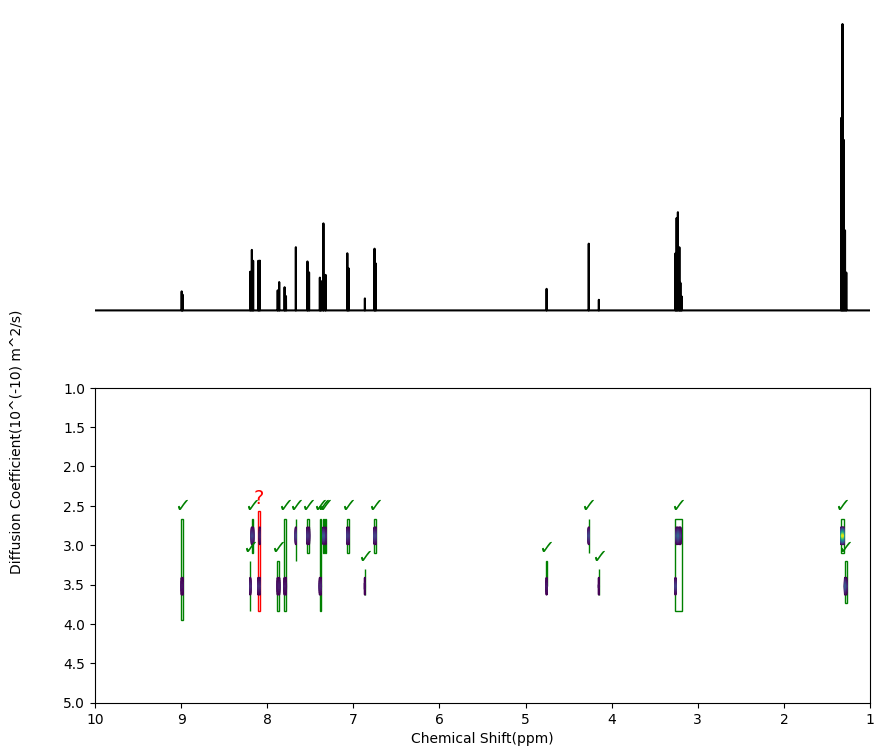

In [2]:
for Type in ["QGC", "GSP", "M6", "QG", "JNN", "TSP", "BPP1", "BPP2", "EC", "AMDK"]:
    process_data_and_plot(Type)

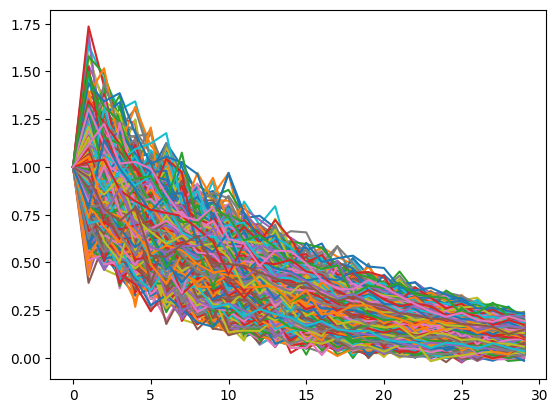

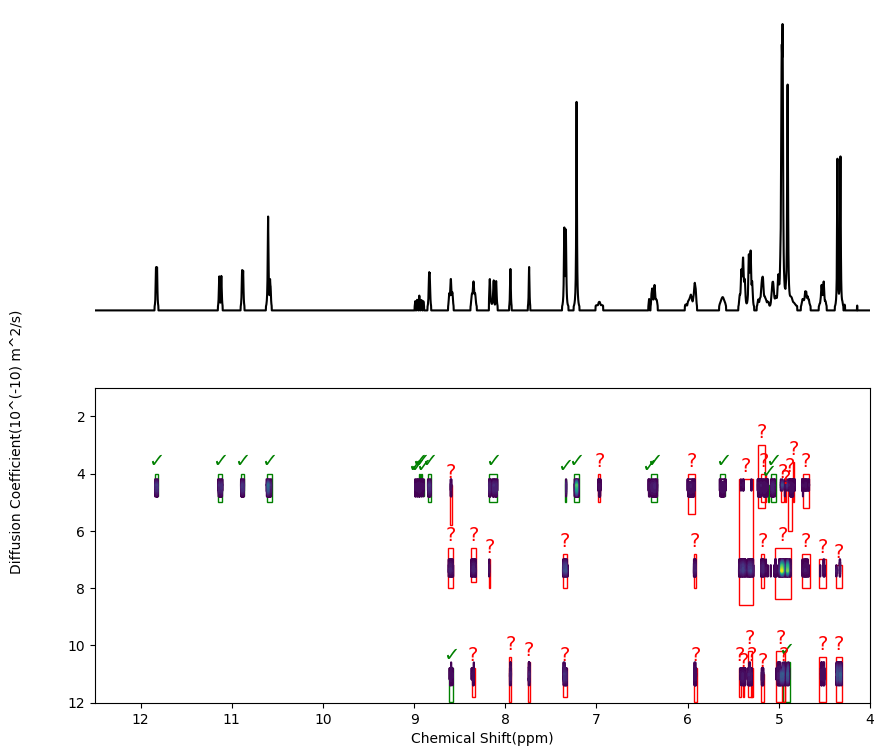

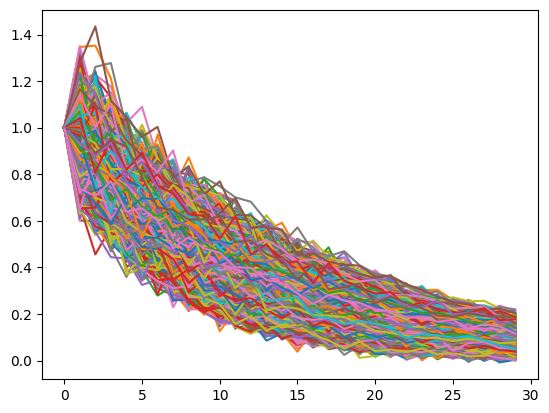

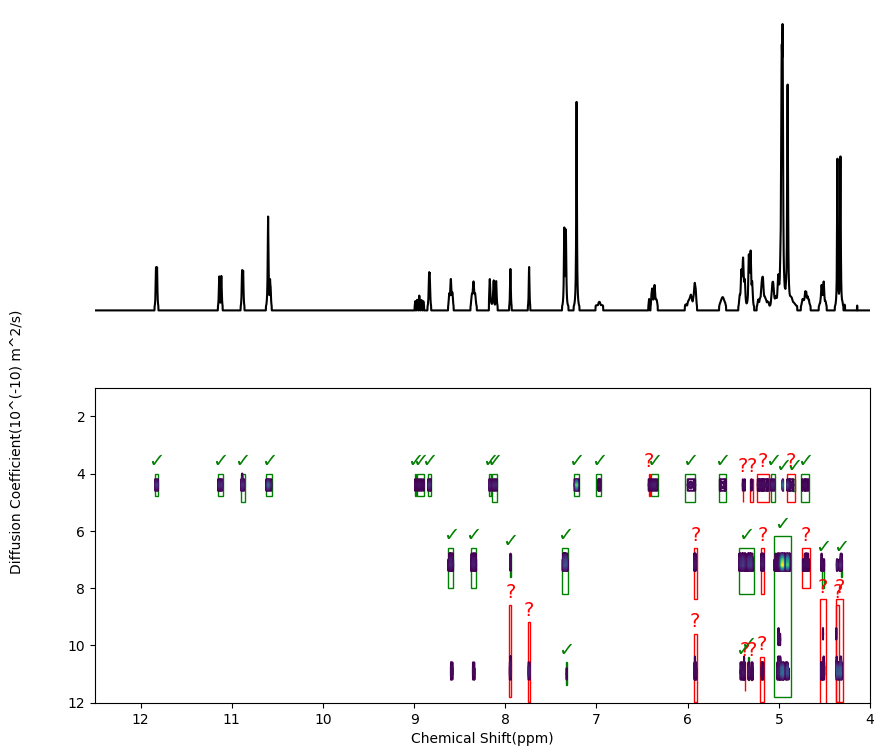

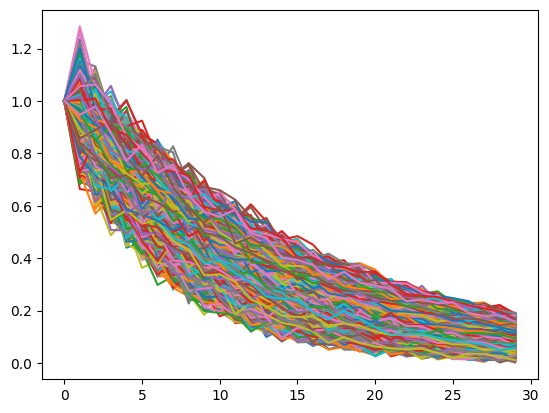

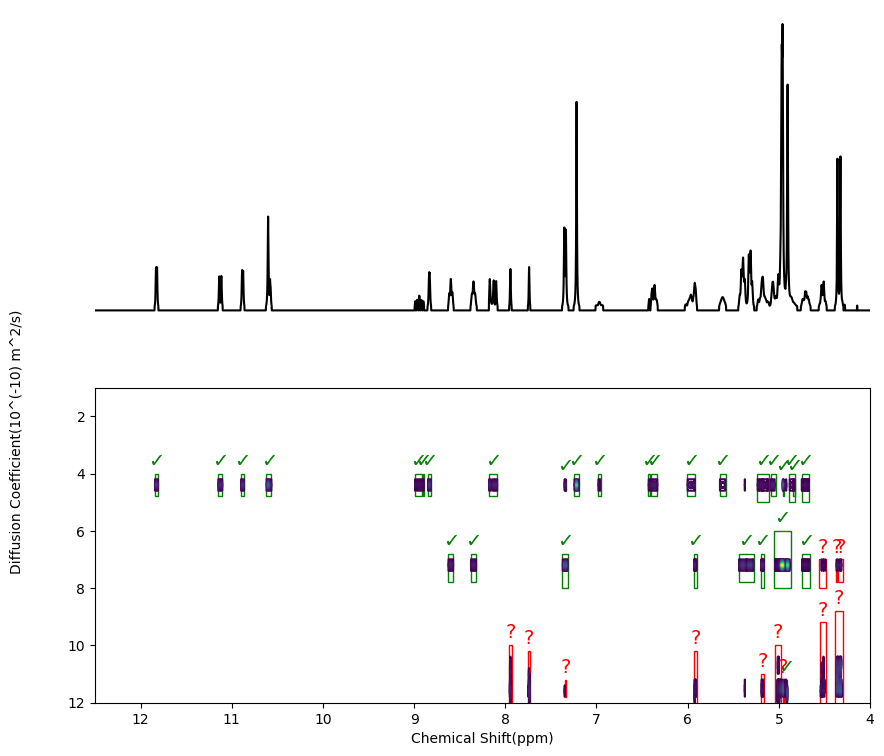

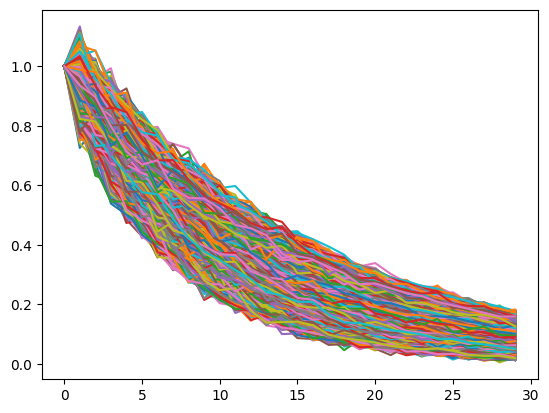

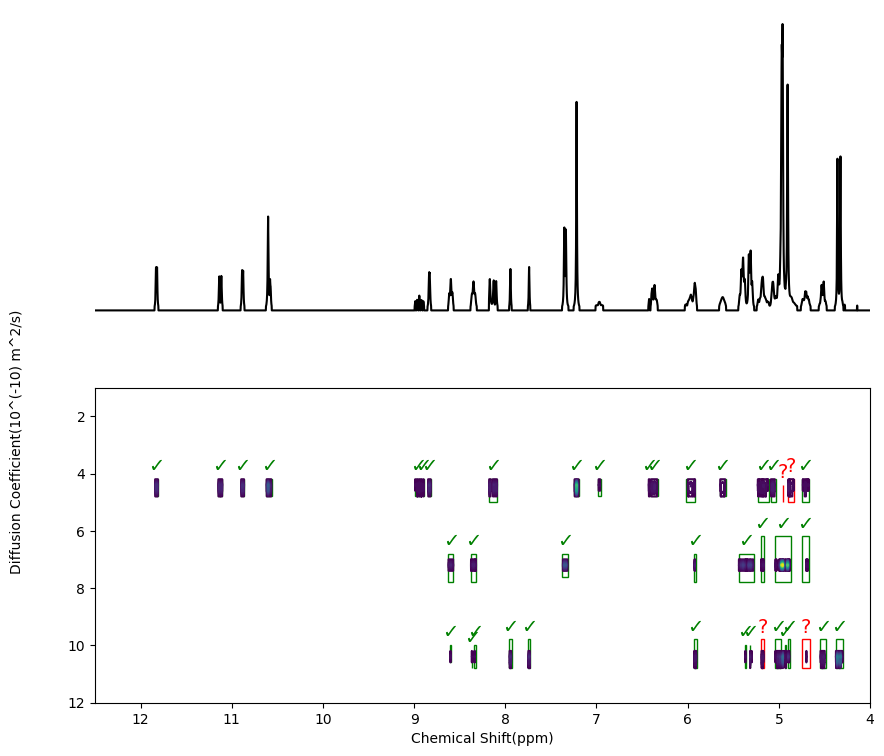

In [3]:
for noise in np.arange(18, 30, 3):
    process_data_and_plot("QGC", noise, save=False)